# アルトコインの価格のビットコインインデックスインデックスの説明

# 1.はじめに
# 2.分析の目的
# 3.データ表示
# 4.データクリーニング
# 5.データ検出
# 6.データの視覚化
# 7.PCA(主成分分析)
# 8.結論

# 1.はじめに

コインの分析をする主な理由は、コインの過去のパフォーマンスと現在までの期間のデータを調査して将来のパフォーマンスを予測するためです。したがって、コインに投資するかどうかの決定は、より良い方法で行われます。このプロジェクトでは、2016年から2021年の間の「YahooFinance」サイトから様々なコインの月間終値データを使用しています。PCA(主成分分析)を使用して、これらのコイン価格のビットコインインデックスの説明について基本的な調査を行いました
# 2.分析の目的

Etherium(ETH)、Ripple(XRP)、Nem(XEM)、Litecoin(LTC)、Stellar(XLM)のコインの2016年から2021年までの月間終値データの分析をし、分析の結果としてコンポーネントのビットコイン(BTC)との類似性を得る。

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt 

from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8,5.5)

# 3.データ表示
データセットを呼び出して、値を調べます。

In [52]:
def csv_data_frame(filename, prefix):
    dates = []
    with open(filename, mode="r") as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
                continue
            date = row["Date"].split("-")[2]
            if date == "01":
                pr = "{}-CLOSE".format(prefix)
                dates.append({ pr: row["Close"], "DATE": row["Date"]})
            line_count += 1
        print(f'Processed {line_count} lines.')
    #print(dates)
    df = pd.DataFrame(dates)
    return df

In [53]:
df1 = csv_data_frame("ETH-USD.csv", "ETH")
df2 = csv_data_frame("XRP-USD.csv", "XRP")
df3 = csv_data_frame("XEM-USD.csv", "XEM")
df4 = csv_data_frame("LTC-USD.csv", "LTC")
df5 = csv_data_frame("XLM-USD.csv", "XLM")
m1 = df1.merge(df2, on="DATE", how="left")
m2 = pd.merge(m1, df3, on="DATE", how="left")
m3 = pd.merge(m2, df4, on="DATE", how="left")
m4 = pd.merge(m3, df5, on="DATE", how="left")
m4 = m4[['DATE', "ETH-CLOSE", "XRP-CLOSE", "XEM-CLOSE", "LTC-CLOSE", "XLM-CLOSE"]]

Processed 1828 lines.
Processed 1828 lines.
Processed 1828 lines.
Processed 1828 lines.
Processed 1828 lines.


In [195]:
data = pd.DataFrame({"DATE" : m4["DATE"],
                        "ETH": m4["ETH-CLOSE"],
                       "XRP" : m4["XRP-CLOSE"],
                       "XEM": m4["XEM-CLOSE"],
                      "LTC": m4["LTC-CLOSE"],
                      "XLM": m4["XLM-CLOSE"]}) 
data.head(5)

,DATE,ETH,XRP,XEM,LTC,XLM
0,2016-03-01,7.653690,0.008006,0.000628,3.432970,0.001909
1,2016-04-01,11.663600,0.007418,0.001473,3.239950,0.002047
2,2016-05-01,8.846500,0.006791,0.001606,3.705200,0.001883
3,2016-06-01,14.001500,0.005809,0.002034,4.740990,0.001525
4,2016-07-01,12.199500,0.006787,0.010477,4.255970,0.002035


In [65]:
data.to_csv('data.csv', index=False)

In [56]:
data.tail()

,DATE,ETH,XRP,XEM,LTC,XLM
55,2020-10-01,353.231293,0.238361,0.118136,46.283146,0.073404
56,2020-11-01,396.358185,0.239797,0.098224,55.587624,0.078478
57,2020-12-01,587.324158,0.612923,0.190341,85.435768,0.184425
58,2021-01-01,730.367554,0.237444,0.222339,126.230347,0.132408
59,2021-02-01,1369.040527,0.371509,0.264058,131.951935,0.321835


# 4.データクリーニング

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 6 columns):
DATE    60 non-null object
ETH     60 non-null object
XRP     60 non-null object
XEM     60 non-null object
LTC     60 non-null object
XLM     60 non-null object
dtypes: object(6)
memory usage: 3.3+ KB


NULL値を調査してます。

In [58]:
data.isnull().sum()*100/data.count()

DATE   0.000
ETH    0.000
XRP    0.000
XEM    0.000
LTC    0.000
XLM    0.000
dtype: float64

NULL値はありません。

In [28]:
m4 = m4['XRP-CLOSE'].astype('float64') 

In [124]:
data1 = pd.read_csv('data.csv')

In [125]:
data2 = pd.DataFrame({"DATE" : data1["DATE"],
                        "ETH": data1["ETH"],
                       "XRP" : data1["XRP"],
                       "XEM": data1["XEM"],
                      "LTC": data1["LTC"],
                      "XLM": data1["XLM"]})

データ内の外れ値を探しています。

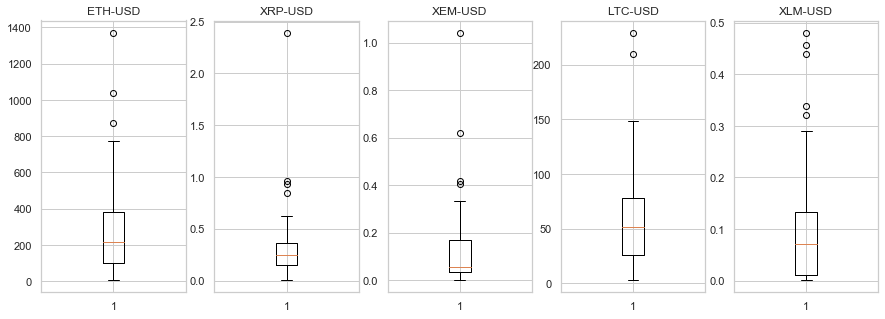

In [128]:
plt.figure(figsize = (15,5))

plt.subplot(1,5,1)
plt.boxplot(data2['ETH'])
plt.title("ETH-USD")

plt.subplot(1,5,2)
plt.boxplot(data2['XRP'])
plt.title("XRP-USD")

plt.subplot(1,5,3)
plt.boxplot(data2['XEM'])
plt.title("XEM-USD")

plt.subplot(1,5,4)
plt.boxplot(data2['LTC'])
plt.title("LTC-USD")

plt.subplot(1,5,5)
plt.boxplot(data2['XLM'])
plt.title("XLM-USD")
plt.show()

上記の表を調べると、データに外れ値があります。Tukey's Range Testを使用して外れ値を調査してます。

In [203]:
q75, q25 = np.percentile(data2["ETH"], [75 ,25])
caa= q75 - q25
esik_degerleri=pd.DataFrame(columns=('threshold_value', 'number_of_outliers'))
for esik_degeri in np.arange(1,5,0.5):
    min_deger = q25 - (caa*esik_degeri)
    maks_deger = q75 + (caa*esik_degeri)
    aykiri_deger_sayisi = len((np.where((data2["ETH"] > maks_deger)| 
                                       (data2["ETH"] < min_deger))[0]))
    esik_degerleri = esik_degerleri.append({'threshold_value': esik_degeri,'number_of_outliers': aykiri_deger_sayisi}, 
                                           ignore_index=True)
esik_degerleri

,threshold_value,number_of_outliers
0,1.000,6.000
1,1.500,3.000
2,2.000,2.000
3,2.500,1.000
4,3.000,1.000
5,3.500,1.000
6,4.000,0.000
7,4.500,0.000


Text(0.5, 1.0, 'Winsorize ETH')

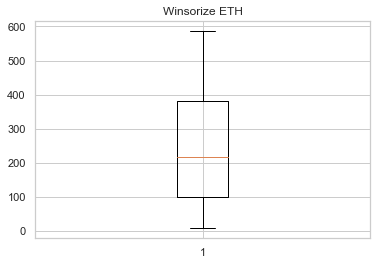

In [130]:
data2['wins_eth'] = winsorize(data2["ETH"], (0, 0.10))
plt.boxplot(data2['wins_eth'])
plt.title("Winsorize ETH")

In [204]:
q75, q25 = np.percentile(data2["XRP"], [75 ,25])
caa= q75 - q25
esik_degerleri=pd.DataFrame(columns=('threshold_value', 'number_of_outliers'))
for esik_degeri in np.arange(1,5,0.5):
    min_deger = q25 - (caa*esik_degeri)
    maks_deger = q75 + (caa*esik_degeri)
    aykiri_deger_sayisi = len((np.where((data2["XRP"] > maks_deger)| 
                                       (data2["XRP"] < min_deger))[0]))
    esik_degerleri = esik_degerleri.append({'threshold_value': esik_degeri,'number_of_outliers': aykiri_deger_sayisi}, 
                                           ignore_index=True)
esik_degerleri

,threshold_value,number_of_outliers
0,1.000,6.000
1,1.500,4.000
2,2.000,4.000
3,2.500,3.000
4,3.000,1.000
5,3.500,1.000
6,4.000,1.000
7,4.500,1.000


Text(0.5, 1.0, 'Winsorize XRP')

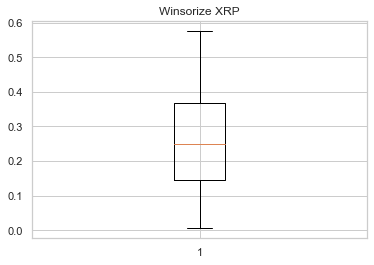

In [132]:
data2['wins_xrp'] = winsorize(data2["XRP"], (0, 0.10))
plt.boxplot(data2['wins_xrp'])
plt.title("Winsorize XRP")

In [205]:
q75, q25 = np.percentile(data2["XEM"], [75 ,25])
caa= q75 - q25
esik_degerleri=pd.DataFrame(columns=('threshold_value', 'number_of_outliers'))
for esik_degeri in np.arange(1,5,0.5):
    min_deger = q25 - (caa*esik_degeri)
    maks_deger = q75 + (caa*esik_degeri)
    aykiri_deger_sayisi = len((np.where((data2["XEM"] > maks_deger)| 
                                       (data2["XEM"] < min_deger))[0]))
    esik_degerleri = esik_degerleri.append({'threshold_value': esik_degeri,'number_of_outliers': aykiri_deger_sayisi}, 
                                           ignore_index=True)
esik_degerleri

,threshold_value,number_of_outliers
0,1.000,5.000
1,1.500,4.000
2,2.000,2.000
3,2.500,2.000
4,3.000,2.000
5,3.500,1.000
6,4.000,1.000
7,4.500,1.000


Text(0.5, 1.0, 'Winsorize XEM')

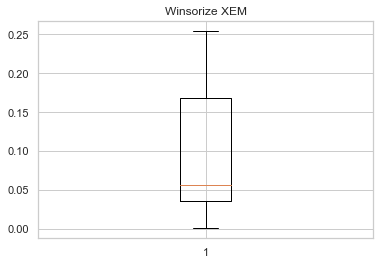

In [134]:
data2['wins_xem'] = winsorize(data2["XEM"], (0, 0.10))
plt.boxplot(data2['wins_xem'])
plt.title("Winsorize XEM")

In [206]:
q75, q25 = np.percentile(data2["LTC"], [75 ,25])
caa= q75 - q25
esik_degerleri=pd.DataFrame(columns=('threshold_value', 'number_of_outliers'))
for esik_degeri in np.arange(1,5,0.5):
    min_deger = q25 - (caa*esik_degeri)
    maks_deger = q75 + (caa*esik_degeri)
    aykiri_deger_sayisi = len((np.where((data2["LTC"] > maks_deger)| 
                                       (data2["LTC"] < min_deger))[0]))
    esik_degerleri = esik_degerleri.append({'threshold_value': esik_degeri,'number_of_outliers': aykiri_deger_sayisi}, 
                                           ignore_index=True)
esik_degerleri

,threshold_value,number_of_outliers
0,1.000,5.000
1,1.500,2.000
2,2.000,2.000
3,2.500,1.000
4,3.000,0.000
5,3.500,0.000
6,4.000,0.000
7,4.500,0.000


Text(0.5, 1.0, 'Winsorize LTC')

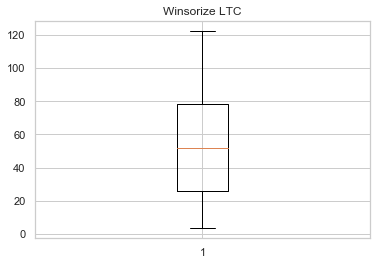

In [136]:
data2['wins_ltc'] = winsorize(data2["LTC"], (0, 0.10))
plt.boxplot(data2['wins_ltc'])
plt.title("Winsorize LTC")

In [207]:
q75, q25 = np.percentile(data2["XLM"], [75 ,25])
caa= q75 - q25
esik_degerleri=pd.DataFrame(columns=('threshold_value', 'number_of_outliers'))
for esik_degeri in np.arange(1,5,0.5):
    min_deger = q25 - (caa*esik_degeri)
    maks_deger = q75 + (caa*esik_degeri)
    aykiri_deger_sayisi = len((np.where((data2["XLM"] > maks_deger)| 
                                       (data2["XLM"] < min_deger))[0]))
    esik_degerleri = esik_degerleri.append({'threshold_value': esik_degeri,'number_of_outliers': aykiri_deger_sayisi}, 
                                           ignore_index=True)
esik_degerleri

,threshold_value,number_of_outliers
0,1.000,8.000
1,1.500,5.000
2,2.000,3.000
3,2.500,3.000
4,3.000,0.000
5,3.500,0.000
6,4.000,0.000
7,4.500,0.000


Text(0.5, 1.0, 'Winsorize XLM')

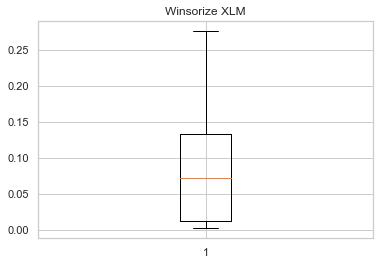

In [138]:
data2['wins_xlm'] = winsorize(data2["XLM"], (0, 0.10))
plt.boxplot(data2['wins_xlm'])
plt.title("Winsorize XLM")

# 5.データ検出

In [139]:
print(data2.describe())

           ETH    XRP    XEM     LTC    XLM  wins_eth  wins_xrp  wins_xem  \
count   60.000 60.000 60.000  60.000 60.000    60.000    60.000    60.000   
mean   271.442  0.304  0.124  58.971  0.105   239.263     0.256     0.098   
std    271.837  0.352  0.171  49.660  0.120   189.622     0.182     0.089   
min      7.654  0.005  0.001   3.240  0.002     7.654     0.005     0.001   
25%     99.782  0.145  0.035  25.582  0.012    99.782     0.145     0.035   
50%    216.014  0.249  0.056  51.726  0.071   216.014     0.249     0.056   
75%    381.005  0.366  0.168  78.452  0.133   381.005     0.366     0.168   
max   1369.041  2.391  1.041 229.033  0.480   587.324     0.576     0.255   

       wins_ltc  wins_xlm  
count    60.000    60.000  
mean     54.767     0.094  
std      39.543     0.093  
min       3.240     0.002  
25%      25.582     0.012  
50%      51.726     0.071  
75%      78.452     0.133  
max     122.584     0.276  


価格平均が最も高いコインは239.263でEtheriumです。

# 6.データの視覚化

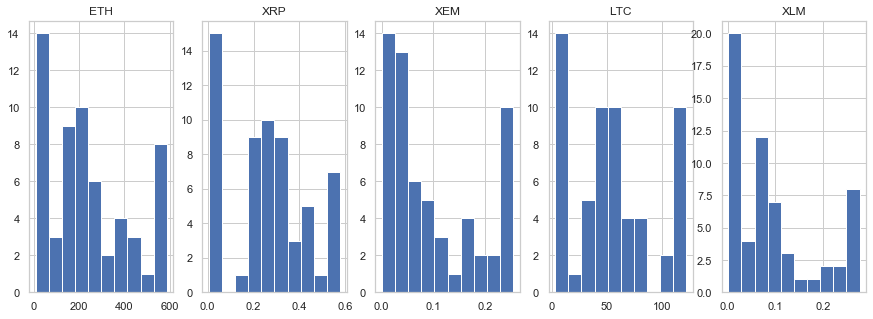

In [140]:
plt.figure(figsize = (15,5))

plt.subplot(1,5,1)
plt.hist(data2['wins_eth'])
plt.title("ETH")

plt.subplot(1,5,2)
plt.hist(data2['wins_xrp'])
plt.title("XRP")

plt.subplot(1,5,3)
plt.hist(data2['wins_xem'])
plt.title("XEM")

plt.subplot(1,5,4)
plt.hist(data2['wins_ltc'])
plt.title("LTC")

plt.subplot(1,5,5)
plt.hist(data2['wins_xlm'])
plt.title("XLM")
plt.show()

ETH値とXEM値の間には類似点があります。XRP値とLTC値の間には類似点があります。XLMは他のコインとの比率が少し異なります。

# Etherium月間終値グラフ

Text(0, 0.5, 'ETH')

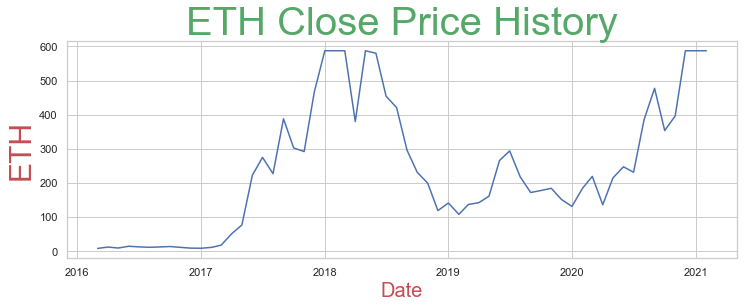

In [209]:
data2['DATE'] = pd.to_datetime(data2.DATE,format='%Y-%m-%d')
data2.index = data2['DATE']

#plot
plt.figure(figsize=(12,4))
plt.plot(data2['wins_eth'], label='Close Price history')
plt.title("ETH Close Price History",fontsize=40,color='g')
plt.xlabel("Date",fontsize=20,color='r')
plt.ylabel("ETH",fontsize=30,color='r')

# Ripple月間終値グラフ

Text(0, 0.5, 'XRP')

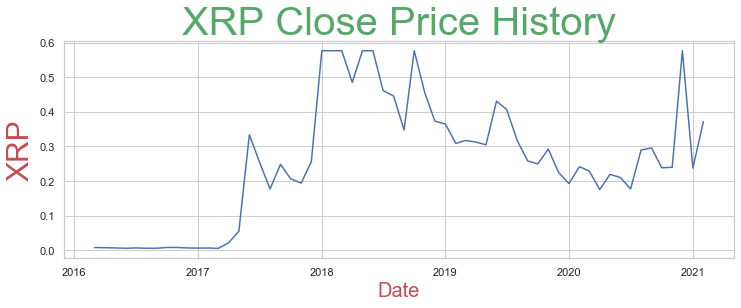

In [210]:
data2['DATE'] = pd.to_datetime(data2.DATE,format='%Y-%m-%d')
data2.index = data2['DATE']

#plot
plt.figure(figsize=(12,4))
plt.plot(data2['wins_xrp'], label='Close Price history')
plt.title("XRP Close Price History",fontsize=40,color='g')
plt.xlabel("Date",fontsize=20,color='r')
plt.ylabel("XRP",fontsize=30,color='r')

# Nem月間終値グラフ

Text(0, 0.5, 'XEM')

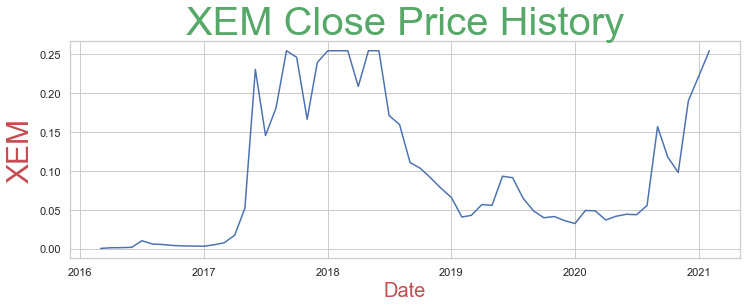

In [211]:
data2['DATE'] = pd.to_datetime(data2.DATE,format='%Y-%m-%d')
data2.index = data2['DATE']

#plot
plt.figure(figsize=(12,4))
plt.plot(data2['wins_xem'], label='Close Price history')
plt.title("XEM Close Price History",fontsize=40,color='g')
plt.xlabel("Date",fontsize=20,color='r')
plt.ylabel("XEM",fontsize=30,color='r')

# Litecoin月間終値グラフ

Text(0, 0.5, 'LTC')

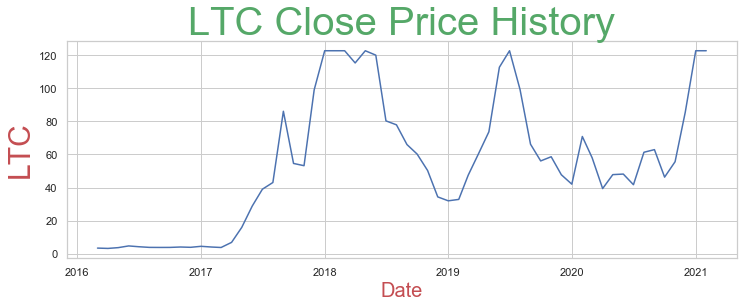

In [212]:
data2['DATE'] = pd.to_datetime(data2.DATE,format='%Y-%m-%d')
data2.index = data2['DATE']

#plot
plt.figure(figsize=(12,4))
plt.plot(data2['wins_ltc'], label='Close Price history')
plt.title("LTC Close Price History",fontsize=40,color='g')
plt.xlabel("Date",fontsize=20,color='r')
plt.ylabel("LTC",fontsize=30,color='r')

# Stellar月間終値グラフ

Text(0, 0.5, 'XLM')

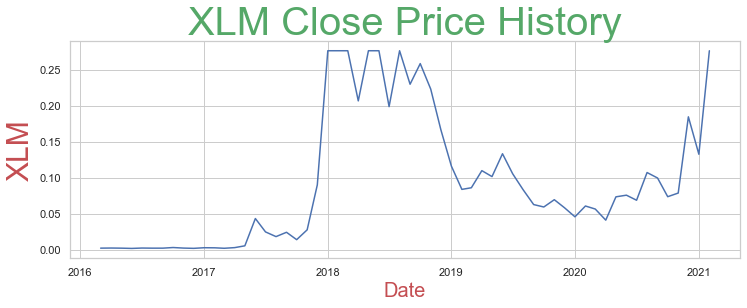

In [213]:
data2['DATE'] = pd.to_datetime(data2.DATE,format='%Y-%m-%d')
data2.index = data2['DATE']

#plot
plt.figure(figsize=(12,4))
plt.plot(data2['wins_xlm'], label='Close Price history')
plt.title("XLM Close Price History",fontsize=40,color='g')
plt.xlabel("Date",fontsize=20,color='r')
plt.ylabel("XLM",fontsize=30,color='r')

In [199]:
data4 = pd.DataFrame({"DATE" : data2["DATE"],
                        "ETH": data2["wins_eth"],
                       "XRP" : data2["wins_xrp"],
                       "XEM": data2["wins_xem"],
                      "LTC": data2["wins_ltc"],
                      "XLM": data2["wins_xlm"]})
data4.head()

,DATE,ETH,XRP,XEM,LTC,XLM
DATE,,,,,,
2016-03-01,2016-03-01,7.654,0.008,0.001,3.433,0.002
2016-04-01,2016-04-01,11.664,0.007,0.001,3.240,0.002
2016-05-01,2016-05-01,8.847,0.007,0.002,3.705,0.002
2016-06-01,2016-06-01,14.002,0.006,0.002,4.741,0.002
2016-07-01,2016-07-01,12.200,0.007,0.010,4.256,0.002


# 変数間の相関

In [200]:
cormat = data4.corr()
cormat

,ETH,XRP,XEM,LTC,XLM
ETH,1.000,0.789,0.887,0.878,0.766
XRP,0.789,1.000,0.705,0.834,0.901
XEM,0.887,0.705,1.000,0.770,0.648
LTC,0.878,0.834,0.770,1.000,0.772
XLM,0.766,0.901,0.648,0.772,1.000


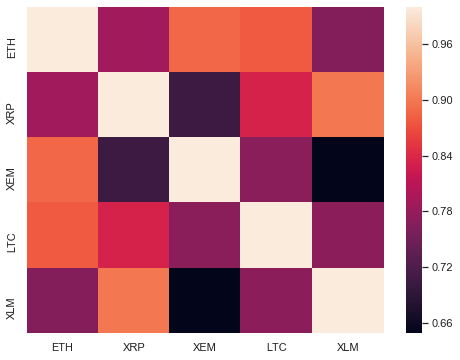

In [201]:
plt.figure(figsize = (8,6))
sns.heatmap(cormat)
plt.show()

相関値は一般的に高いですが、Etheriumの方が他のコインより最も高いです。

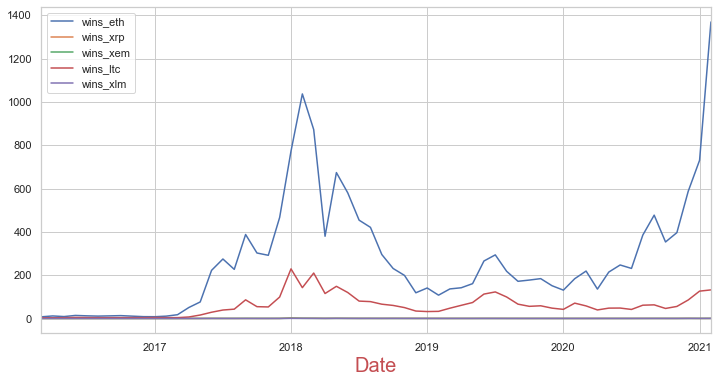

In [202]:
fig = plt.figure(figsize = (12, 6))

data2['DATE'] = pd.to_datetime(data2.DATE,format='%Y-%m-%d')
data2.index = data2['DATE']
data2['ETH'].plot(label = 'wins_eth')
data2['XRP'].plot(label = 'wins_xrp')
data2['XEM'].plot(label = 'wins_xem')
data2['LTC'].plot(label = 'wins_ltc')
data2['XLM'].plot(label = 'wins_xlm')
plt.xlabel("Date",fontsize=20,color='r')
plt.legend()

グラフを見ると、Etheriumは他のコインと比較して非常に活発な増加を示しています。

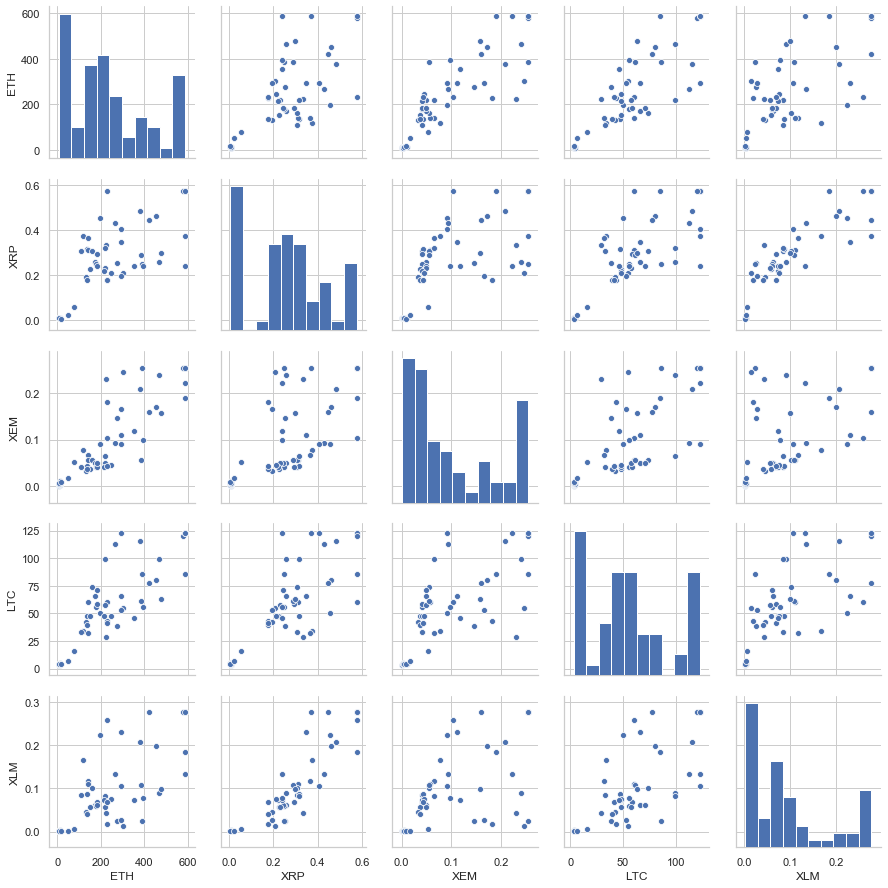

In [151]:
data3 = pd.DataFrame({"DATE" : data2["DATE"],
                        "ETH": data2["wins_eth"],
                       "XRP" : data2["wins_xrp"],
                       "XEM": data2["wins_xem"],
                      "LTC": data2["wins_ltc"],
                      "XLM": data2["wins_xlm"]})

sns.pairplot(data3)

# Bitcoinの月間終値データ分析

In [152]:
df6 = csv_data_frame("BTC-USD.csv", "BTC")

Processed 1828 lines.


In [154]:
btc=pd.read_csv('btcdata.csv')
btc1 = pd.DataFrame({"DATE" : data1["DATE"],
                        "BTC": btc["BTC-CLOSE"]})

In [155]:
btc1.head()

,DATE,BTC
0,2016-03-01,435.123
1,2016-04-01,417.960
2,2016-05-01,451.875
3,2016-06-01,536.920
4,2016-07-01,676.296


In [156]:
btc1.tail()

,DATE,BTC
55,2020-10-01,10623.330
56,2020-11-01,13737.109
57,2020-12-01,18802.998
58,2021-01-01,29374.152
59,2021-02-01,33537.176


In [157]:
btc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
DATE    60 non-null object
BTC     60 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


NULL値を調査してます。

In [158]:
btc1.isnull().sum()*100/btc1.count()

DATE   0.000
BTC    0.000
dtype: float64

NULL値はありません。

外れ値を見てみましょう。

Text(0.5, 1.0, 'BTC')

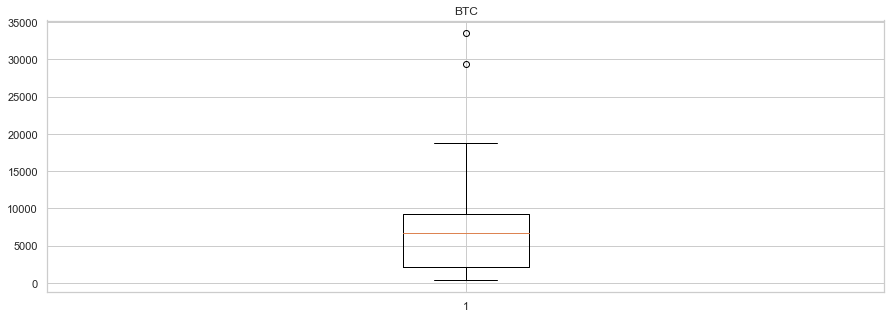

In [159]:
plt.figure(figsize = (15,5))

plt.boxplot(btc1['BTC'])
plt.title("BTC")

Winsorizeメソッドを使用して、外れ値を取り除く

Text(0.5, 1.0, 'Winsorize BTC')

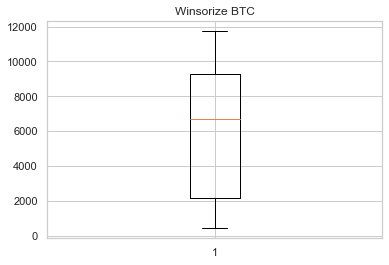

In [160]:
btc1['wins_btc'] = winsorize(btc1["BTC"], (0, 0.10))
plt.boxplot(btc1['wins_btc'])
plt.title("Winsorize BTC")

# Bitcoin月間終値グラフ

Text(0, 0.5, 'BTC')

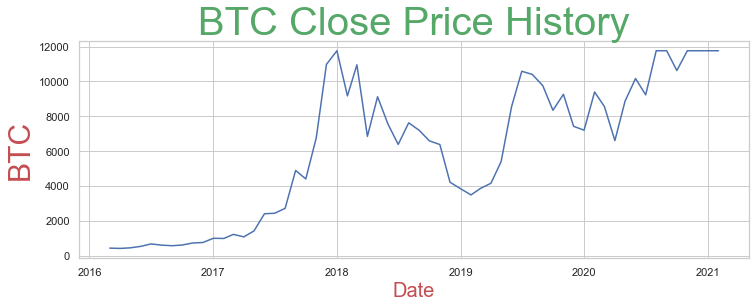

In [208]:
btc1['DATE'] = pd.to_datetime(btc1.DATE,format='%Y-%m-%d')
btc1.index = btc1['DATE']

#plot
plt.figure(figsize=(12,4))
plt.plot(btc1['wins_btc'], label='Close Price history')
plt.title("BTC Close Price History",fontsize=40,color='g')
plt.xlabel("Date",fontsize=20,color='r')
plt.ylabel("BTC",fontsize=30,color='r')

# 7.PCA(主成分分析)

In [162]:
X =data2.iloc[:,1:6]
print (X)

                ETH   XRP   XEM     LTC   XLM
DATE                                         
2016-03-01    7.654 0.008 0.001   3.433 0.002
2016-04-01   11.664 0.007 0.001   3.240 0.002
2016-05-01    8.847 0.007 0.002   3.705 0.002
2016-06-01   14.002 0.006 0.002   4.741 0.002
2016-07-01   12.200 0.007 0.010   4.256 0.002
2016-08-01   10.942 0.006 0.006   3.863 0.002
2016-09-01   11.995 0.006 0.006   3.832 0.002
2016-10-01   13.173 0.008 0.004   3.849 0.003
2016-11-01   10.766 0.008 0.004   4.088 0.002
2016-12-01    8.453 0.007 0.004   3.909 0.002
2017-01-01    8.173 0.006 0.003   4.512 0.002
2017-02-01   10.732 0.007 0.005   4.075 0.002
2017-03-01   17.350 0.005 0.008   3.799 0.002
2017-04-01   50.700 0.022 0.018   6.884 0.003
2017-05-01   76.297 0.055 0.052  15.918 0.005
2017-06-01  222.239 0.334 0.231  28.803 0.043
2017-07-01  274.601 0.255 0.146  38.988 0.024
2017-08-01  226.769 0.177 0.181  43.036 0.018
2017-09-01  387.741 0.248 0.332  86.040 0.024
2017-10-01  302.337 0.207 0.246  5

[83.8  8.2  4.4  3.   0.7]


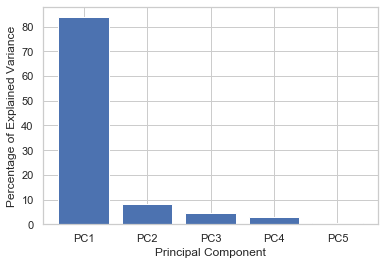

In [170]:
scaled_data = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1) 
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
print (per_var)
plt.show()

最初の基本コンポーネントは分散の83.8％を説明するので、最初の基本コンポーネントを取得して分散を説明できます。

新しいコンポーネントとインデックスの相関関係を見てみましょう。

In [214]:
btc2=btc1['wins_btc']
print(btc2[0])

435.122986


In [215]:
np.corrcoef(pca_data[:,0],btc2)

array([[1.        , 0.64288183],
       [0.64288183, 1.        ]])

相関が高いです。

Text(0, 0.5, 'BTC')

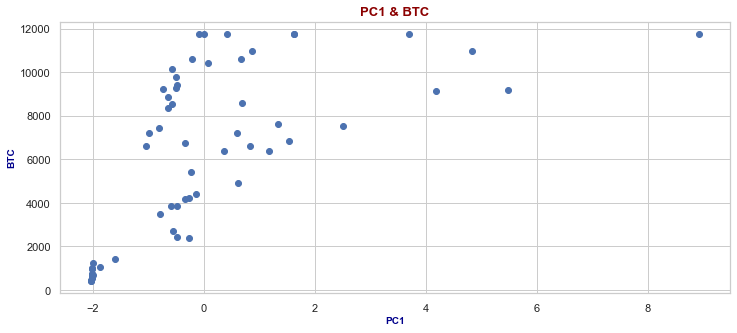

In [216]:
plt.figure(figsize=(12,5))
baslik_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 13 }
eksen_font  = {'family': 'arial', 'color': 'darkblue','weight': 'bold','size': 10 }
plt.scatter(pca_data[:,0], btc2)
plt.title("PC1 & BTC", fontdict=baslik_font)
plt.xlabel('PC1', fontdict=eksen_font )
plt.ylabel('BTC', fontdict=eksen_font )

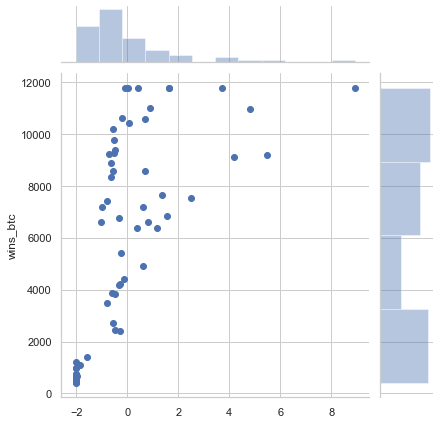

In [217]:
sns.jointplot(pca_data[:,0],btc2,kind='scatter')

# 8.結論

2016年から2021年の間に5アルトコイン（Etherium, Ripple, Nem, Litecoin, Stellar）の月間終値でデータセットを作成し、探索的データ分析を実行してグラフが描かれました。 それらの関係を調査したところ、相関性が高いことがわかりました。 次に、PCAが適用され、83.8％の分散が最初の主成分によって説明されることが決定されました。 次に、この基本成分とビットBitcoinインデックスの相関を調査したところ、正の相関があることがわかりました。 結果として、これらの5つのコインのデータを分析する代わりに、Bitcoinインデックスに対するこれらのコインの影響を説明するには、1つの基本的なコンポーネントで十分である可能性があります。